In [1]:
import math
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso, HuberRegressor
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.pipeline import Pipeline

mpl.rcParams['figure.dpi'] = 80
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)
%load_ext autoreload
%autoreload 2

ecmwf_path = "data/preprocessed/US/ecmwf_era_wheat_US.csv"
predictor_path = "data/preprocessed/US/ndvi_soil_soil_moisture_meteo_fpar_wheat_US_v2.csv"
yield_path = "data/CY-Bench/US/wheat/yield_wheat_US.csv"
shapefile_path = "data/shapefiles/US/tl_2023_us_county/tl_2023_us_county.shp"
relevant_adm_ids = [i.strip("\n").strip().strip("'") for i in open("data/great_plains_wheat_US.txt", "r").read().split(',')]
static_features = ["awc", "bulk_density", "drainage_class_2", "drainage_class_3", "drainage_class_4", "drainage_class_5", "drainage_class_6"]
great_plains = {'08': 'Colorado', '20': 'Kansas', '31': 'Nebraska', '40': 'Oklahoma', '46': 'South Dakota', '48': 'Texas'}
statefp_dict = {'01': 'ALABAMA', '02': 'ALASKA', '04': 'ARIZONA', '05': 'ARKANSAS', '06': 'CALIFORNIA', '08': 'COLORADO', '09': 'CONNECTICUT', '10': 'DELAWARE', '11': 'DISTRICT OF COLUMBIA', '12': 'FLORIDA', '13': 'GEORGIA', '15': 'HAWAII', '16': 'IDAHO', '17': 'ILLINOIS', '18': 'INDIANA', '19': 'IOWA', '20': 'KANSAS', '21': 'KENTUCKY', '22': 'LOUISIANA', '23': 'MAINE', '24': 'MARYLAND', '25': 'MASSACHUSETTS', '26': 'MICHIGAN', '27': 'MINNESOTA', '28': 'MISSISSIPPI', '29': 'MISSOURI', '30': 'MONTANA', '31': 'NEBRASKA', '32': 'NEVADA', '33': 'NEW HAMPSHIRE', '34': 'NEW JERSEY', '35': 'NEW MEXICO', '36': 'NEW YORK', '37': 'NORTH CAROLINA', '38': 'NORTH DAKOTA', '39': 'OHIO', '40': 'OKLAHOMA', '41': 'OREGON', '42': 'PENNSYLVANIA', '44': 'RHODE ISLAND', '45': 'SOUTH CAROLINA', '46': 'SOUTH DAKOTA', '47': 'TENNESSEE', '48': 'TEXAS', '49': 'UTAH', '50': 'VERMONT', '51': 'VIRGINIA', '53': 'WASHINGTON', '54': 'WEST VIRGINIA', '55': 'WISCONSIN', '56': 'WYOMING'}
temporal_prefixes = ["tavg", "prec", "tmin", "tmax", "ndvi", "fpar", "rad", "et0", "cwb", "ssm", "rsm"]

In [3]:
us = gpd.read_file(shapefile_path)
us = us.assign(adm_id="US-" + us["STATEFP"] + "-" + us["COUNTYFP"])
study_region = (us
                .loc[us["STATEFP"].isin(great_plains.keys()), ["STATEFP", "adm_id", "geometry"]]
                .assign(state_name=lambda x: x["STATEFP"].map(great_plains))
                .reset_index(drop=True)
                )

In [4]:
study_region.head()

,STATEFP,adm_id,geometry,state_name
0,31,US-31-039,"POLYGON ((-96.55515 41.91587, -96.55515 41.914...",Nebraska
1,31,US-31-109,"POLYGON ((-96.68493 40.52330, -96.69219 40.523...",Nebraska
2,31,US-31-129,"POLYGON ((-98.27370 40.11840, -98.27374 40.122...",Nebraska
3,46,US-46-099,"POLYGON ((-96.45339 43.57994, -96.45339 43.579...",South Dakota
4,48,US-48-327,"POLYGON ((-99.77120 30.71079, -99.78240 30.710...",Texas


In [193]:
def get_yield_and_predictors(yield_path, predictor_path):
    """
    Load yield and predictors data, merge them, filter by year and admin_ids, and return the resulting dataframe.    
    Params:
        yield_path: str, path to the yield data
        predictor_path: str, path to the cy-bench data
    Returns:
        x_y: pd.DataFrame, merged dataframe
    """
    y = pd.read_csv(yield_path).set_index("adm_id").drop(columns=["country_code", "crop_name", "production"])
    cy_bench = pd.read_csv(predictor_path)
    x_y = cy_bench.merge(y, on=["adm_id", "harvest_year"], how="inner")
    # to bring harvest year and yield columns to the front
    x_y = x_y.set_index(["adm_id", "harvest_year", "yield"]).reset_index()
    return x_y

def filter_by_year(df, start_year, end_year):
    """
    Filter dataframe by years.
    
    Params:
        df: pd.DataFrame, dataframe containing the years
        start_year: int, start year to filter by
        end_year: int, end year to filter by
    
    Returns:
        df_filtered: pd.DataFrame, filtered dataframe
    """
    df_filtered = df.loc[df["harvest_year"].between(start_year, end_year)].reset_index(drop=True)
    return df_filtered

def filter_by_state(df, study_region):
    """
    Filter dataframe by admin_ids.
    
    Params:
        df: pd.DataFrame, dataframe containing the admin_ids
        study_region: GeoDataframe, containing the admin_ids to filter by
    
    Returns:
        df_filtered: pd.DataFrame, filtered dataframe
    """
    df_filtered = df.loc[df["adm_id"].isin(study_region["adm_id"].unique())].reset_index(drop=True)
    return df_filtered

def filter_by_complete_time_series(df, completeness_threshold, start_year, end_year):
    """
    Filter dataframe by completeness threshold.
    
    Params:
        df: pd.DataFrame, dataframe containing the time series
        completeness_threshold: float, minimum percentage of years that should be available for each adm_id
        start_year: int, start year of the period to consider
        end_year: int, end year of the period to consider
    
    Returns:
        df_filtered: pd.DataFrame, filtered dataframe
    """
    number_of_years = int(math.ceil(completeness_threshold * (end_year - start_year + 1)))
    complete_areas = (
        df.loc[df["harvest_year"].between(start_year, end_year)]
        .groupby("adm_id")
        .size()
        .reset_index(name="count")
        .loc[lambda x: x["count"] >= number_of_years, "adm_id"]
        .unique()
        .tolist()
    )
    
    df_filtered = df.loc[df["adm_id"].isin(complete_areas)].reset_index(drop=True)
    return df_filtered

def get_temporal_feature_subset(df, feature_prefix_list):
    """
    Filter temporal features by prefix and return the resulting list of features names.
    
    Params:
        df: pd.DataFrame, dataframe containing the features as column names
        feature_prefix_list: list, list of prefixes to filter by
    
    Returns:
        filtered_temporal_features: list, list of filtered temporal feature names
    """
    all_columns = df.columns
    filtered_temporal_features = [f for f in all_columns if any([f.startswith(prefix) for prefix in feature_prefix_list])]
    return filtered_temporal_features

def temporal_aggregation(df, feature_prefix_list, window_size, yield_column="yield", keep_static=False):
    """
    Aggregate steps of temporal features and return the resulting dataframe.
    
    Params:
        df: pd.DataFrame, dataframe containing the features and time steps as column names
        feature_prefix_list: list, list of prefixes of temporal features that should be aggregated
        steps: int, number of steps to aggregate by
        yield_column: str, name of the yield column
        keep_static: boolean, if non-temporal features should be kept
    """
    features_to_keep = [yield_column, "harvest_year"]
    if keep_static: features_to_keep.extend(static_features)
    li = []
    df = df.set_index(features_to_keep, append=True)
    for feature in feature_prefix_list:
        li.append(df[get_temporal_feature_subset(df, [feature])].rolling(window=window_size, step=window_size, closed="right", axis=1).mean().dropna(axis=1))
    
    df = pd.concat(li, axis=1).reset_index().set_index("adm_id")
    return df

def interpolate_fpar_timesteps(df, reference_quantity):
    """
    interpolate fpar values for all timesteps of a reference quantity.
    
    Params:
        df: pd.DataFrame, dataframe containing the fpar columns
        reference_quantity: str, reference quantity with complete timesteps
        
    Returns:
        df: pd.DataFrame, dataframe with interpolated fpar values
    
    """
    min_time_step = min([int(c.split("_")[1]) for c in [l for l in df.columns if reference_quantity in l]])
    max_time_step = max([int(c.split("_")[1]) for c in [l for l in df.columns if reference_quantity in l]])
    fpar_columns = [c for c in df.columns if "fpar" in c]
    fpar_columns_all_timesteps = ["fpar_{}".format(n) for n in list(range(min_time_step, max_time_step + 1))]
    new_fpar_columns = list(set(fpar_columns_all_timesteps).difference(set(fpar_columns)))
    df[new_fpar_columns] = np.nan
    df[fpar_columns_all_timesteps] = df[fpar_columns_all_timesteps].interpolate(method='linear', axis=1, limit_direction='both')
    df = df.reindex(sorted(df.columns), axis=1)
    
    return df

def linear_detrend(df):
    """
    Linear detrend the yield data.
    
    Params:
        df: pd.DataFrame, dataframe containing the yield data
        
    Returns:
        df: pd.DataFrame, dataframe with the detrended yield data
    """
    #df["yield_detrended_huber"] = np.nan
    df["yield_detrended"] = np.nan
    for region in df["adm_id"].unique():
        x = df.loc[df["adm_id"] == region, "harvest_year"]
        y = df.loc[df["adm_id"] == region, "yield"]
        #model = HuberRegressor().fit(x.to_frame(), y.to_frame().values.ravel())
        #slope = model.coef_[0]
        #bias = model.intercept_
        #print(slope)
        #x_detrended_huber = 100 * (y - slope * x - bias) / (slope * x + bias)
        slope, bias = np.polyfit(x, y, 1)
        #print(slope)
        x_detrended = 100 * (y - slope * x - bias) / (slope * x + bias)
        #df.loc[df["adm_id"] == region, "yield_detrended_huber"] = x_detrended_huber
        df.loc[df["adm_id"] == region, "yield_detrended"] = x_detrended
    df = df.set_index(["adm_id", "yield_detrended"]).reset_index(level=[1])
     
    return df

def moving_average_detrend(df, window_size):
    """
    Moving average detrend the yield data.
    
    Params:
        df: pd.DataFrame, dataframe containing the yield data
        window_size: int, size of the window to calculate the moving average
        
    Returns:
        df: pd.DataFrame, dataframe with the detrended yield data
    """
    df["yield_detrended"] = np.nan
    for region in df["adm_id"].unique():
        y = df.loc[df["adm_id"] == region, "yield"]
        y_detrended = y.rolling(window=window_size, min_periods=1, center=True).mean()
        df.loc[df["adm_id"] == region, "yield_detrended"] = y_detrended
    df = df.set_index(["adm_id", "yield_detrended"]).reset_index(level=1)
    
    return df

def order_temporal_features(df, temporal_prefixes):
    candidate_columns = [c for c in df.columns if c.split("_")[0] in temporal_prefixes]
    formated_candidate_columns = format_column_names(candidate_columns)
    df = df.rename(columns=dict(zip(candidate_columns, formated_candidate_columns)))
    df = df.reindex(sorted(df.columns), axis=1)
    df = df.set_index(["harvest_year", "yield"], append=True).reset_index(level=[1,2])
    return df
    
def format_column_names(column_names):
    formatted_columns = []
    for name in column_names:
        prefix, number = name.split('_')
        formatted_name = f"{prefix}_{int(number):02d}"
        formatted_columns.append(formatted_name)
    return formatted_columns

def calculate_correlation(df):	
    """
    Calculate the correlation between the yield and the temporal features.
    
    Params:
        df: pd.DataFrame, dataframe containing the yield and the temporal features
        
    Returns:
        df: pd.DataFrame, dataframe with the correlation values
    """
    corr = df.corr().loc["yield_detrended", :]
    corr = corr.drop("yield_detrended")
    return corr

def filter_by_harvest_intensity(df, study_region, intensity_threshold):
    """
    Filter the dataframe by harvest intensity of adm_ids.
    
    Params:
        df: pd.DataFrame, dataframe containing the yield data
        study_region: GeoDataFrame, containing the polygons of the adm_ids
        intensity_threshold: float, threshold to filter by
        
    Returns:
        df: pd.DataFrame, dataframe with the filtered yield data
    """
    df = gpd.GeoDataFrame(df.merge(study_region[["geometry", "adm_id"]], on="adm_id", how="left"), geometry="geometry")
    df = df.assign(intensity=10000 * df["harvest_area"]/df["geometry"].to_crs(epsg=32723).area)
    adm_ids = df.loc[df["intensity"] > intensity_threshold, "adm_id"].unique().tolist()
    df = df.loc[df["adm_id"].isin(adm_ids)].reset_index(drop=True).drop(columns=["intensity", "harvest_area", "geometry"])
    
    return df

<Axes: ylabel='Frequency'>

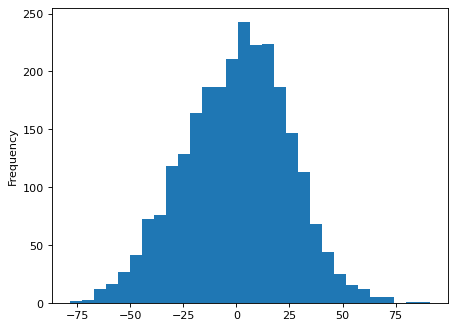

In [194]:
xy = get_yield_and_predictors(yield_path, predictor_path)
xy = filter_by_state(xy, study_region)
xy = filter_by_year(xy, 2002, 2022)
xy = filter_by_harvest_intensity(xy, study_region, 0.05)
xy = filter_by_complete_time_series(xy, .7, 2002, 2022)
xy = linear_detrend(xy)
xy["yield_detrended"].plot(kind="hist", bins=30)


____

In [195]:
xy_fpar_ssm_size2 = temporal_aggregation(xy, ["prec", "tavg", "fpar"], 2, yield_column="yield_detrended", keep_static=True)

means = xy_fpar_ssm_size2.assign(state=xy_fpar_ssm_size2.index.str.split("-").str[1].map(statefp_dict)).groupby("state").transform("mean")
means = means[~means.index.duplicated(keep='first')]
stds = xy_fpar_ssm_size2.assign(state=xy_fpar_ssm_size2.index.str.split("-").str[1].map(statefp_dict)).groupby("state").transform("std")
stds = stds[~stds.index.duplicated(keep='first')]

xy_normalized = (xy_fpar_ssm_size2 - means) / stds
xy_normalized = xy_normalized.dropna(axis=1)

groups = xy_normalized["harvest_year"] 
X = xy_normalized.drop(["yield_detrended"], axis=1)
y = xy_fpar_ssm_size2["yield_detrended"]

print(X.columns)
model = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=50)
#pipe = Pipeline([('standardscaler', StandardScaler()), ('model', RandomForestRegressor(n_jobs=1))])
outer_cv = LeaveOneGroupOut()
outer_scores = []
list_of_estimations = []
for train_idx, test_idx in outer_cv.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    model.fit(X_train.drop("harvest_year", axis=1), y_train)
    y_pred = model.predict(X_test.drop("harvest_year", axis=1))
    
    df = pd.DataFrame({"obs": y_test, "est": y_pred})
    list_of_estimations.append(df)
    #outer_scores.append(r2_score(y_test, y_pred))
results = pd.concat(list_of_estimations)
print(r2_score(results["obs"], results["est"]), mean_absolute_error(results["obs"], results["est"]))         

Index(['harvest_year', 'awc', 'bulk_density', 'prec_03', 'prec_05', 'prec_07',
       'prec_09', 'prec_11', 'prec_13', 'prec_15', 'prec_17', 'prec_19',
       'prec_21', 'prec_23', 'prec_25', 'prec_27', 'prec_29', 'tavg_03',
       'tavg_05', 'tavg_07', 'tavg_09', 'tavg_11', 'tavg_13', 'tavg_15',
       'tavg_17', 'tavg_19', 'tavg_21', 'tavg_23', 'tavg_25', 'tavg_27',
       'tavg_29', 'fpar_03', 'fpar_05', 'fpar_07', 'fpar_09', 'fpar_11',
       'fpar_13', 'fpar_15', 'fpar_17', 'fpar_19', 'fpar_21', 'fpar_23',
       'fpar_25', 'fpar_27', 'fpar_29'],
      dtype='object')
0.31361441583792493 15.97807441530821


In [196]:
root_mean_squared_error(results["obs"], results["est"])

20.500564208268752